# Introduction


In this notebook, we will explore how to build a machine learning model for classifying images using PyTorch, a widely used and adopted deep learning library for production and research. PyTorch has become a popular choice among researchers and machine learning practitioners because of its dynamic approach and flexibility for building and training complex models.

One of the distinct advantages of PyTorch is its focus on **dynamic programming**. Unlike some other deep learning libraries, PyTorch allows you to build and modify computational graphs on the fly, providing great flexibility for designing models and performing interactive experiments. In addition, PyTorch has a **large user community and detailed documentation**, making it easy to learn and troubleshoot.

Throughout this notebook, we will discover how to take full advantage of PyTorch's capabilities to build, train and evaluate our image classification model. From data preparation to implementing optimization techniques, we will explore the essential fundamentals so that you can develop your skills in the exciting field of machine learning with PyTorch. This notebook follows a basic machine learning workflow

### Index
1. Data structure in Pytorch: Tensors
2. Data Loading and Visualization: CIFAR10
3. Define a Convolutional Neural Network
4. Define a Loss function
5. Define a Optimizer
6. Train the network on the training data
7. Test the network on the test data


In [ ]:
#@title load libraries

import time
import random

import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#@title utilities


def load_data(batch_size=512, pre_load=True):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

  if pre_load:
    train_data = [ sample for sample in trainloader ]
    test_data  = [ sample for sample in testloader  ]
    return train_data, test_data
  return trainloader, testloader

class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res


def acc_barplot(history, ax, xlabel=None):
    """
    this function plots the training and testing history for n models in a barplot

    Parameters:
    -----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics
    """

    ax.set_xlabel('Models') if xlabel is None else ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of Models (Train vs Test)')



    models = [ f'{e["name"]}' for i, e in enumerate(history) ]
    #check repeated name values
    models = [ models[i] + '_' if models[i] in models[:i] else models[i] for i in range(len(models)) ]

    accs = [ model['acc'][-1] for model in history ]
    val_accs = [ model['val_acc'][-1] for model in history ]
    acc = accs + val_accs

    ax.set_ylim (min(acc) - 10, max(acc) + 5)

    hue_labels = ['train'] * len(accs) + ['test'] * len(val_accs)

    sns.set(style="whitegrid")
    sns.barplot(x=models * 2, y=acc, hue=hue_labels, ax=ax)

def batch_lineplot(history, ax, acc = True):
    """
    This function plots the training and testing history for n models

    Parameters:
    ----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics

    """

    plt.gca().set_prop_cycle(None)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Accuracy') if acc else ax.set_ylabel('Loss')
    ax.set_title('Accuracy of Models (Train vs Test)') if acc else ax.set_title('Loss of Models (Train vs Test)')

    metric = 'acc' if acc else 'loss'
    val_metric = 'val_acc' if acc else 'val_loss'

    metrics = [ model[metric] for model in history ]

    val_metrics = [ model[val_metric] for model in history ]

    sns.set(style="whitegrid")

    for i,acc in enumerate(metrics):
        sns.lineplot(x=range(len(acc)), y=acc, label=f'{history[i]["name"]}', ax=ax)

    ax.set_prop_cycle(None)

    for i, val_acc in enumerate(val_metrics):
        sns.lineplot(x=range( len(metrics[0])//(len(val_metrics[i])), len(metrics[0])+1, len(metrics[0])//(len(val_metrics[i]))), y=val_acc
                     , marker='o', markersize=7, linestyle='--',  ax=ax)


def plot_tensor_resul(tensor_a, tensor_b, resul, label_resul=""):
    plt.subplot(1, 3, 1)
    plt.title("a")
    plt.imshow(tensor_a, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    # display values as text inside the matrix
    for (i, j), z in np.ndenumerate(tensor_a):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')


    plt.subplot(1, 3, 2)
    plt.title("b")
    plt.imshow(tensor_b, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    for (i, j), z in np.ndenumerate(tensor_b):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')


    plt.subplot(1, 3, 3)
    plt.title(label_resul)
    plt.imshow(a_plus_b, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    for (i, j), z in np.ndenumerate(resul):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')

    plt.show()


#@title Validation
def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):

        data_time.update(time.time() - end)

        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print(f'Test: \tTime {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
        f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
        f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
        f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')

    return losses.avg, top1.avg

### 1. Data structure in Pytorch: Tensors


<div align="center"><img src="https://miro.medium.com/v2/resize:fit:880/1*WbLIc4-xIOfHiO2oWzimyA.png" width="700"></div>


In pytorch, tensors are the main data structure. They are similar to numpy arrays, but they can be used on GPU to accelerate computing.
There are several ways to create tensors in pytorch.

1. From a list or numpy array
2. From a random number generator
3. From a file





In [ ]:
# 1.1 Create a tensor from a list

data = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

tensor_from_list = torch.tensor(data, dtype=torch.int32)
print(tensor_from_list)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)


In [ ]:
# 1.2. Create a tensor from a numpy array

data = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

tensor_from_numpy = torch.from_numpy(data)
print(tensor_from_numpy)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


In [ ]:
# 2. Create a tensor from a random number generator

tensor_randn = torch.randint(3, 10, (3, 3), dtype=torch.int32)

print(tensor_randn)


tensor([[7, 5, 7],
        [7, 9, 4],
        [8, 8, 9]], dtype=torch.int32)


The tensors in pytorch have various attributes, where its most important attributes are:

- shape: the shape of the tensor (number of dimensions and number of elements in each dimension) and can be accessed by `tensor.shape()` or `tensor.size()`
- dtype: the data type of the tensor (float, int, etc.) and can be accessed by `tensor.dtype`
- device: the device where the tensor is stored (CPU or GPU) and can be accessed by `tensor.device`

In [ ]:
# Display main attributes of a tensor

tensor = torch.rand(3, 4)

print("tensor: ", tensor)
print("tensor.shape: ", tensor.shape)
print("tensor.dtype: ", tensor.dtype)
print("tensor.device: ", tensor.device)

tensor:  tensor([[0.8778, 0.7573, 0.1937, 0.2309],
        [0.8711, 0.3525, 0.5910, 0.0895],
        [0.0100, 0.6835, 0.7418, 0.5012]])
tensor.shape:  torch.Size([3, 4])
tensor.dtype:  torch.float32
tensor.device:  cpu


## 1. Basics algebraic operations with PyTorch tensors

1. Addition of two tensors
2. Element-wise multiplication of two tensors
3. Matrix multiplication
4. Dot product


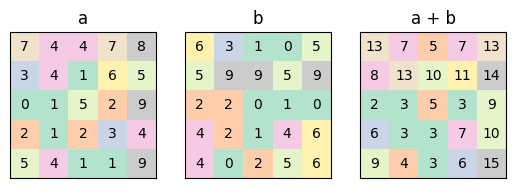

In [ ]:
#@title Addition of two tensors

tensor_a = torch.randint(0, 10, (5, 5))
tensor_b = torch.randint(0, 10, (5, 5))

# 1. Addition of two tensors
a_plus_b = tensor_a + tensor_b

# visualizing the addition with matplotlib
plot_tensor_resul(tensor_a, tensor_b, a_plus_b, "a + b")

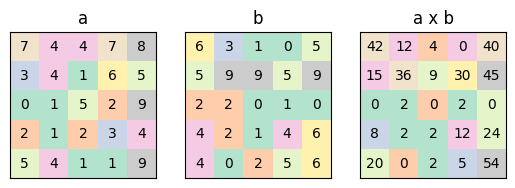

In [ ]:
#@title Elementwise multiplication of two tensors

a_times_b = torch.mul(tensor_a, tensor_b)
plot_tensor_resul(tensor_a, tensor_b, a_times_b, "a x b")

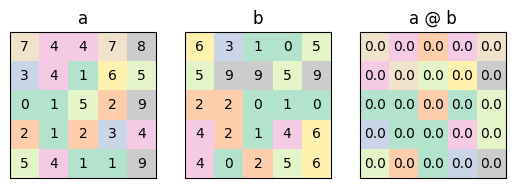

In [ ]:
#@title (Practice) Matrix multiplication

a_matmul_b = torch.zeros(5,5) # COMPLETE HERE

plot_tensor_resul(tensor_a, tensor_b, a_matmul_b, "a @ b")

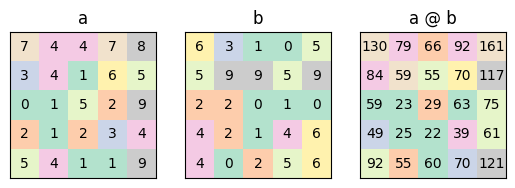

In [ ]:
#@title (SOLUTION)

a_matmul_b = torch.matmul(tensor_a, tensor_b)
plot_tensor_resul(tensor_a, tensor_b, a_matmul_b, "a @ b")

## 2. Data Loading and Visualization: CIFAR10

Embrace the power of data, for it holds the key to unlocking the true potential of Artificial Intelligence. In the ever-evolving landscape of technology, the surge of data in the last decades has been truly remarkable. With each passing year, there has been an explosive growth in the volume, velocity, and variety of data generated by individuals, businesses, and connected devices. This data deluge has become the fuel that propels the engine of AI forward, driving it to new heights of innovation and discovery.

As data is loaded into the algorithms, it breathes life into the machine, granting it the ability to learn, adapt, and transform the world. Each data point represents a valuable piece of knowledge, and every dataset becomes a rich tapestry of information. The challenges of preprocessing and organizing the data are to be approached with determination, for with each step, AI gains the power to revolutionize industries, solve complex problems, and make a profound impact on humanity.

Normalization is crucial in data preprocessing for machine learning. By centering data around zero and adjusting its scale, training stability improves, preventing vanishing or exploding gradients. Furthermore, normalization reduces the negative impact of outliers, enhancing effective generalization to new data and preventing overfitting.

$$
\textbf{x}'=\frac{\textbf{x}-mean}{std}
$$

* $\textbf{x}$ is the value of the tensor you want to normalize.
* $\textbf{x}'$ is the normalized value of the tensor.
* $mean$ is the mean of the tensor's values in the dataset.
* $std$ is the standard deviation of the tensor's values in the data.

Fortunately, PyTorch has different tools for that, such as:
1. [torchvision](https://pytorch.org/vision/stable/index.html) Library:
 Is a part of PyTorch that provides popular datasets, model architectures, and various image transformation functions for computer vision tasks.

2. [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html): This submodel within torchvision porvides functions to create and load popular datasets, such as CIFAR-10, MNIST, and ImageNet. (In this notebook is used the CIFAR-10 dataset.)
3. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) module: This module contains various image transformation functions that help in pre-processing the dataset before feeding it to a neural network.






In [ ]:
#@title Load  Cifar10 dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#  Data Transformation:
#  Define the transformation pipeline for data preprocessing.
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

#  Load Training Data:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#  Create a DataLoader for training data:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

#  Load Test Data:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#  Create a DataLoader for test data:
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

#  Preload Data:

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

Files already downloaded and verified
Files already downloaded and verified


### 2.1 Data Visualization

Before training a neural network, it is essential to comprehend the data being used. Data visualization allos exploring the structure, distribution, and patterns present in the data. This helps to detect possible anomalies, imbalances, or noise that could affect the performance of the network. Also, datavisualization can help identify the need for certain transformations or preprocessing steps before feeding the data to the neural network. For example, normalizing features.

The CIFAR-10 dataset consists of 60000 colour images $\textbf{x}$ of size 32x32 size in 10 classes $\textbf{y}$; the dataset's classes include: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Each class contains 6000 images. There are 50000 training images and 10000 test images.

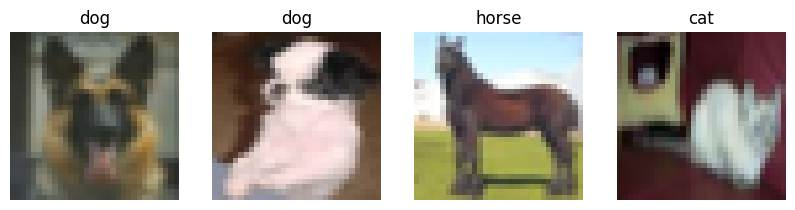

In [ ]:
#@title Visualize data with labels

# Define the class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)

# Get a batch of random training images and their corresponding labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Visualize the images with labels
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


## 3. Convolutional Neural Network



important to consider:

1. [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

--------------------


Al definir el una arquitectura de red neural se emplean 3 componentes principales

* Capa de entrada: El modelo recibe de entrada la imagen $\textbf{x}$
* Capas ocultas: Diferentes capas lineales y no lineas que extraen caracteristicas de la imagen
* Capa de salida: Funcion de activación para realizar la predición de un tarea especifica (regresion, clasificación) $\textbf{y}$





<div align="center"><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width="700"></div>


The hidden layer in model can be different types of linear and non-linear mathematical functions, in the case of the proposed architecture, the model consists of the following components:

`Input Layer`: Accepts 3-channel (RGB) images as input.

`Convolutional Layers`: The network starts with a convolutional layer called [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)*(in_channels, out_channels, kernel_size, stride, padding)* where *in_channels* is the number of input channels, *out_channels* is the number of convolutional filters, *kernel_size* is the size of the kernel, *stride* is the convolution stride, and *padding* defines the amount of implicit paddings.

followed by [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)*(num_features)* where *num_features* is the number of features. Then, a configurable number of additional convolutional layers are added, each followed by batch normalization and a [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu)() activation function. These layers capture hierarchical features from the input images.

`Max Pooling`: After each convolutional layer, [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)*(kernel_size, stride, padding)*. This downsamples the feature maps, reducing their spatial dimensions.

`Flattening`: The feature maps are flattened into a 1D vector to be processed by the fully connected layers using the [Flatten]() function.

`Fully Connected Layers`: A single [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)*(in_features, out_features)* is added, where in_features is the number of input features and out_features is the number of output features. This takes the flattened feature vector as input. The output size of this layer is determined by the number of target classes (in this case, 10 classes).

`Last Activation`: The fully connected layer is followed by a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax)*(dim)* activation function where dim is the dimension along which softmax is applied. This obtains the class probabilities.


### Defined Convolutional Neural Network

Finally, the entery process that perform the convolutionl neural network can be mathematically defines as


$$
\hat{\textbf{y}} = \mathcal{M}_{\theta} (\textbf{x})
$$

In [ ]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):


    # description: what means and what can i do in the __init__ function?
    def __init__(self, features=16, num_layers=4, img_size=32, name="ClassificationNet"):
        super(ClassificationNet, self).__init__()
        self.name = name

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

     # description: what means and what can i do in the forward function?
    def forward(self, x):
        return self.model(x)

In [ ]:
# Create model

model = ClassificationNet()

## 4. **Define cost function**: Categorical Cross-Entropy


$$
\mathcal{L}_{ce} = - \sum_{i=1}^C \textbf{y}_i \cdot \log( \hat{\textbf{y}_i})
$$

* $C$ is the number of classes
* $\textbf{y}$ is the true label vector
* $\hat{\textbf{y}}$ is the network prediction, $\hat{\textbf{y}} = \mathcal{M}_\theta(\textbf{x})$


[Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
# Define cost function

criterion = nn.CrossEntropyLoss()

## 5. Define optimizer: Gradient Descent (GD)

### Gradient Descent (GD)

Gradient Descent is an optimization algorithm for finding a local minimum of a differentiable function. Gradient descent in machine learning and deep learning is simply used to find the values of a function's parameters (coefficients) that minimize a cost function as far as possible.

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \frac{\partial \mathcal{L}_{ce}}{\partial θ}
$$



*   $\theta$ are the network **trainable** parameters
*   $\eta$ is the learning rate


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## 5. Train the network on the training data


Given a set of images and labels $\{ \textbf{x}^{(i)}, \textbf{y}^{(i)} \}_{i}^{N}$ the procedure to obtain optimal network parameters $\theta^*$ given a neural network architecture $\mathcal{M}_\theta$ can be defined as

$$
\theta^* = \underset{\theta}{\text{arg min}} \quad \mathcal{L}_{ce}(\textbf{y}, \underbrace{\mathcal{M}_\theta(\textbf{x})}_{\hat{\textbf{y}}} )
$$

### Training Loop

<div align="center"><img src="https://i.imgur.com/S178PPX.png" width="700" ></div>

In [ ]:
#@title (Practice) Traing a classifier from scratch


# 0. Load the data
train_data, test_data = load_data(batch_size=64)

# 1. Define a Convolutional Neural Network using the ClassificationNet class

model = 0 # TODO

# 2. Define a loss function (use the CrossEntropyLoss class)

criterion = 0 # TODO


# Move model and loss function to GPU to accelerate computation
# model = model.to(device)          # Uncomment
# criterion = criterion.to(device)  # Uncomment



# 3. Define an optimizer (use the SGD class)

optimizer = 0 # TODO

# 4. Train the network for 6 epochs
epochs = 6

for epoch in range(epochs):

    # Put the model in training mode
    model # .train()

    # Iterate over the training dataset
    for i, (images, labels) in enumerate(train_data):

        images, labels = images.to(device), labels.to(device)

        # ------- forward pass ---------
        # 5. Get the predictions from the model
        outputs = 0 # TODO

        # 6. Compute the loss
        loss = 0 # TODO

        # ------- backward pass --------
        # 7. Reset the gradients
        optimizer # TODO
        # 8. Compute the gradients
        loss # TODO
        # 9. Update the parameters
        optimizer # TODO

        # 10. Print the loss every 100 iterations
        if (i+1) % 32 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_data)}], Loss: {loss}')

Epoch [1/6], Step [32/782], Loss: 0
Epoch [1/6], Step [64/782], Loss: 0
Epoch [1/6], Step [96/782], Loss: 0
Epoch [1/6], Step [128/782], Loss: 0
Epoch [1/6], Step [160/782], Loss: 0
Epoch [1/6], Step [192/782], Loss: 0
Epoch [1/6], Step [224/782], Loss: 0
Epoch [1/6], Step [256/782], Loss: 0
Epoch [1/6], Step [288/782], Loss: 0
Epoch [1/6], Step [320/782], Loss: 0
Epoch [1/6], Step [352/782], Loss: 0
Epoch [1/6], Step [384/782], Loss: 0
Epoch [1/6], Step [416/782], Loss: 0
Epoch [1/6], Step [448/782], Loss: 0
Epoch [1/6], Step [480/782], Loss: 0
Epoch [1/6], Step [512/782], Loss: 0
Epoch [1/6], Step [544/782], Loss: 0
Epoch [1/6], Step [576/782], Loss: 0
Epoch [1/6], Step [608/782], Loss: 0
Epoch [1/6], Step [640/782], Loss: 0
Epoch [1/6], Step [672/782], Loss: 0
Epoch [1/6], Step [704/782], Loss: 0
Epoch [1/6], Step [736/782], Loss: 0
Epoch [1/6], Step [768/782], Loss: 0
Epoch [2/6], Step [32/782], Loss: 0
Epoch [2/6], Step [64/782], Loss: 0
Epoch [2/6], Step [96/782], Loss: 0
Epoch [

In [ ]:
#@title Training Function

def train(train_loader, model, criterion, optimizer, epoch, verbose=True):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        image, label = image.to(device), label.to(device)

        data_time.update(time.time() - end)

        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0 and verbose:

            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                f'Time {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
                f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
                f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
                f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')


    return losses.vals, top1.vals

important to consider: toch.optim

Ejemplos optimizadores
Parametros comunes de los optimizadores (learning rate, weight_decay)

In [ ]:
# Move model and loss function to GPU to accelerate computation
model = ClassificationNet()
criterion = nn.CrossEntropyLoss()


criterion = criterion.to(device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# train model for 1000 epochs

epochs = 2
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history['loss'].extend(losses)
    history['acc'].extend(acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


history['name'] = 'model 1'

Starting training epoch 0
Epoch: [0][0/782]	Time 1.676 (1.676)	Data 0.002 (0.002)	Loss 2.2968 (2.2968)	Accuracy 10.938 (10.938)
Epoch: [0][50/782]	Time 0.005 (0.038)	Data 0.000 (0.000)	Loss 2.1994 (2.2541)	Accuracy 26.562 (19.761)
Epoch: [0][100/782]	Time 0.005 (0.022)	Data 0.000 (0.000)	Loss 2.1293 (2.2208)	Accuracy 37.500 (24.381)
Epoch: [0][150/782]	Time 0.005 (0.016)	Data 0.000 (0.000)	Loss 2.1209 (2.1932)	Accuracy 34.375 (27.939)
Epoch: [0][200/782]	Time 0.004 (0.013)	Data 0.000 (0.000)	Loss 2.1264 (2.1713)	Accuracy 35.938 (30.263)
Epoch: [0][250/782]	Time 0.004 (0.012)	Data 0.000 (0.000)	Loss 2.1133 (2.1499)	Accuracy 35.938 (32.869)
Epoch: [0][300/782]	Time 0.006 (0.011)	Data 0.000 (0.000)	Loss 2.0376 (2.1316)	Accuracy 43.750 (34.853)
Epoch: [0][350/782]	Time 0.004 (0.010)	Data 0.000 (0.000)	Loss 2.0822 (2.1155)	Accuracy 35.938 (36.627)
Epoch: [0][400/782]	Time 0.005 (0.009)	Data 0.001 (0.000)	Loss 1.9558 (2.1014)	Accuracy 56.250 (38.077)
Epoch: [0][450/782]	Time 0.004 (0.009)	Da

Starting training epoch 0
Epoch: [0][0/782]	Time 0.009 (0.009)	Data 0.003 (0.003)	Loss 1.8328 (1.8328)	Accuracy 65.625 (65.625)
Epoch: [0][50/782]	Time 0.004 (0.005)	Data 0.000 (0.000)	Loss 1.7933 (1.8229)	Accuracy 68.750 (65.288)
Epoch: [0][100/782]	Time 0.010 (0.005)	Data 0.000 (0.000)	Loss 1.8582 (1.8288)	Accuracy 60.938 (64.650)
Epoch: [0][150/782]	Time 0.006 (0.005)	Data 0.000 (0.000)	Loss 1.8634 (1.8334)	Accuracy 64.062 (64.280)
Epoch: [0][200/782]	Time 0.006 (0.006)	Data 0.000 (0.000)	Loss 1.7724 (1.8347)	Accuracy 70.312 (64.094)
Epoch: [0][250/782]	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 1.7676 (1.8336)	Accuracy 70.312 (64.280)
Epoch: [0][300/782]	Time 0.006 (0.006)	Data 0.000 (0.000)	Loss 1.8621 (1.8336)	Accuracy 64.062 (64.281)
Epoch: [0][350/782]	Time 0.006 (0.006)	Data 0.000 (0.000)	Loss 1.7823 (1.8319)	Accuracy 67.188 (64.383)
Epoch: [0][400/782]	Time 0.006 (0.006)	Data 0.000 (0.000)	Loss 1.8211 (1.8314)	Accuracy 64.062 (64.378)
Epoch: [0][450/782]	Time 0.007 (0.006)	Da

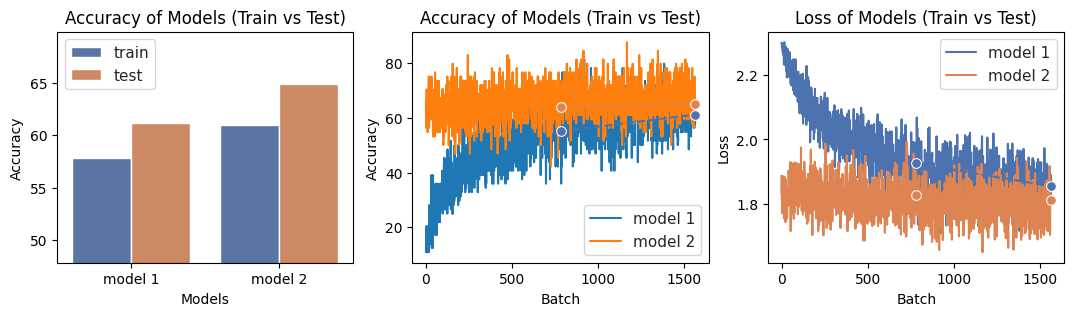

In [ ]:
# this is just for test
# ignore this cell

epochs = 2
history_2 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc  = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history_2['loss'].extend(losses)
    history_2['acc'].extend(acc)
    history_2['val_loss'].append(val_loss)
    history_2['val_acc'].append(val_acc)

history_2['name'] = 'model 2'#model.__class__.__name__

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 3))
acc_barplot(np.array([history,history_2]), ax1)
batch_lineplot(np.array([history,history_2]), ax2)
batch_lineplot(np.array([history,history_2]), ax3, acc=False)

In [ ]:
#@title Tunning Model Function
def tuning_model(parameter_val, epochs, train_data, test_data, optimizer = None,  model = ClassificationNet(), batch=None ):
    """
    this is an auxiliar function to tune hyperparameters of a model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) if optimizer is None else optimizer

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    model = model.to(device)

    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': [],
        'name': ""
    }

    for epoch in range(epochs):

        losses, acc  = train(train_data, model, criterion, optimizer, epoch, verbose=False)

        with torch.no_grad():
            val_loss, val_acc = validate(test_data, model, criterion)

        if batch:
          acc = [np.mean(acc)]

        history['loss'].extend(losses)
        history['acc'].extend(acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    history['name'] = str(parameter_val)

    if isinstance(parameter_val, torch.optim.Optimizer):
        history['name'] = parameter_val.__class__.__name__

    return history

### **Batch-size**


The batch size determines **how many examples are used** together before adjusting the model. Experiments show that using a bigger batch often makes the model perform worse in terms of its ability to understand new things. Picking the right batch size involves carefully finding a balance between how training works and how well the model does. When the batch size gets larger, it can make training more steady and use the computer's power better. However, this might also make the model not as good at understanding new samples, which could lead to it fitting too closely to the training data and not being able to find new patterns in new data.

<div align="center"><img src="https://editor.analyticsvidhya.com/uploads/58182variations_comparison.png" width="700" ></div>



**Low Batch Size**

* **Erratic Gradients:** Gradients dance unpredictably with sparse data.

* **Faster Convergence** Early On: An energetic sprint through initial epochs.

* **Inefficient Hardware Use:** Hardware power underutilized, like a thoroughbred held back.

**Large Batch Size**

* **Smooth Gradients**: Gradients glide steadily, painting a smoother optimization path.

* **Slower Convergence:** A patient marathon, progressing with measured steps.

* **Memory Efficiency:** Hardware harmonized, orchestrating a symphony of efficient computation.

* **Potential Overfitting:** The risk of over-memorization lurks in the vast data expanse.

* **Limited Exploration:** A narrow journey, missing the landscapes of alternative solutions.

Starting training epoch 0
Test: 	Time 0.016 (0.022)	Data 0.000 (0.000)	Loss 1.8841 (1.8854)	Accuracy 59.439 (58.610)
Starting training epoch 1
Test: 	Time 0.014 (0.021)	Data 0.000 (0.000)	Loss 1.8416 (1.8515)	Accuracy 62.372 (61.390)
Starting training epoch 2
Test: 	Time 0.014 (0.022)	Data 0.000 (0.000)	Loss 1.8085 (1.8212)	Accuracy 66.199 (64.260)
Starting training epoch 3
Test: 	Time 0.014 (0.021)	Data 0.000 (0.000)	Loss 1.8121 (1.8169)	Accuracy 65.944 (64.860)
Starting training epoch 4
Test: 	Time 0.013 (0.024)	Data 0.000 (0.000)	Loss 1.7849 (1.7849)	Accuracy 67.347 (67.840)
Starting training epoch 5
Test: 	Time 0.014 (0.022)	Data 0.000 (0.000)	Loss 1.7923 (1.7850)	Accuracy 66.709 (67.750)
Starting training epoch 6
Test: 	Time 0.014 (0.022)	Data 0.000 (0.000)	Loss 1.7654 (1.7704)	Accuracy 69.770 (69.350)
Starting training epoch 7
Test: 	Time 0.014 (0.020)	Data 0.000 (0.000)	Loss 1.7853 (1.7798)	Accuracy 68.495 (68.150)
Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (

Text(0.5, 0, 'epochs')

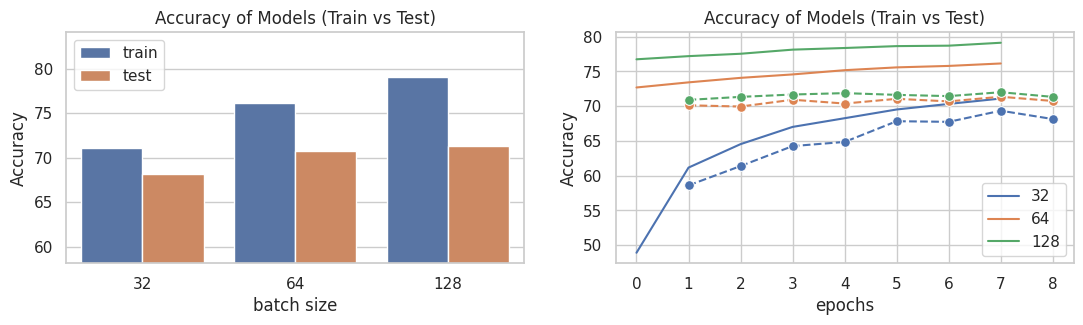

In [ ]:
batch_size_1 = 32   # @param {type:"integer"}
batch_size_2 = 64  # @param {type:"integer"}
batch_size_3 = 128 # @param {type:"integer"}

batch_sizes = [ batch_size_1, batch_size_2, batch_size_3 ]

historys = []

for batch_size in batch_sizes:
        train_data, test_data = load_data(batch_size=batch_size)
        history = tuning_model(batch_size, 8, train_data, test_data, batch=True)
        historys.append(history)


# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

acc_barplot(np.array(historys), ax1, 'batch size')
batch_lineplot(np.array(historys), ax = ax2)
ax2.set_xlabel('epochs')

### learning rate tuning

The learning rate is a hyperparameter that controls how quickly the model learns and adapts to the problem during training. Choosing the right learning rate is important for making sure the model converges efficiently to an optimal solution.

<div align="center"><img src="https://i.imgur.com/1ZPQw1l.png" width="700" ></div>


- **Low Learning Rate**
    - **Training progresses very slowly:** Small updates to parameters lead to slow convergence.

    - **Loss function decreases gently:** The loss reduction might be gradual and time-consuming.

    - **Model may get stuck in suboptimal solution:** The model take longer to escape local minima or saddle points.

- **High Learning Rate**
    - **Training may diverge and become unstable:** Large updates can cause parameter values to fluctuate widly.

    - **Loss function oscillates and diverges:** Loss might increase and decrease erratically.

    - **Model struggles to converge to optimal solution:** Overshooting can prevent the model from settling the minimum.
    
The ideal learning rate is problem-specific and depends on factors like the neural network architecture, complexity of the problem, and size of the dataset. It is common practice to gradually decrease the learning rate as training progresses to allow for more fine-tuned learning in later epochs.


Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0103 (2.0148)	Accuracy 48.469 (48.560)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9427 (1.9412)	Accuracy 54.082 (53.880)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8960 (1.8934)	Accuracy 59.311 (59.280)
Starting training epoch 3
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8626 (1.8604)	Accuracy 60.714 (61.830)
Starting training epoch 4
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8784 (1.8602)	Accuracy 57.908 (61.440)
Starting training epoch 5
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8558 (1.8411)	Accuracy 62.245 (63.490)
Starting training epoch 6
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.8536 (1.8417)	Accuracy 61.352 (62.800)
Starting training epoch 7
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8354 (1.8204)	Accuracy 62.883 (65.010)
Starting training epoch 8
Test: 	Time 0.014 (0.018)	Data 0.000 (

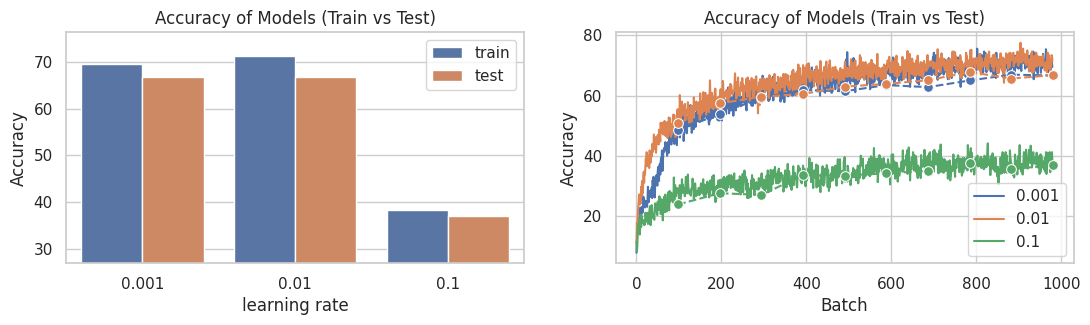

In [ ]:
learning_rate_1 = 1e-3 # @param {type:"number"}
learning_rate_2 = 1e-2 # @param {type:"number"}
learning_rate_3 = 1e-1 # @param {type:"number"}


lrs = [learning_rate_1, learning_rate_2, learning_rate_3]

historys = []
train_data, test_data = load_data(batch_size=512)


for lr in lrs:
            model = ClassificationNet()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            history = tuning_model(lr, 10, train_data, test_data, optimizer, model)
            historys.append(history)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
acc_barplot(np.array(historys), ax1, 'learning rate')
batch_lineplot(np.array(historys), ax = ax2)

### optimizer tuning

Optimization refers to the process of adjusting the model's parameters in order to minimize a loss function. The choice of optimization algorithm and its hyperparameters can significantly impact the efficiency and effectiveness of the training process.

<div align="center"><img src="https://api.wandb.ai/files/lavanyashukla/images/projects/36993/2a6f771c.gif" width="450" ></div>

- **Faster Optimizer**
    - **Quicker convergence:** Faster optimizers, like Adam, tend to converge more quickly to a solution.

    - **Adaptive learning rate:** Adaptive optimizers adjust learning rates, allowing them to respond quickly to changes in the loss landscape.

    - **Risk of overshooting:** Faster optimizers can sometimes overshoot the optimal solution, leading to oscillations around the minimum.
    
    - **Potential overfitting:** Rapid convergence might make the model prone to overfitting, especially if the learning rate is not properly tuned.

- **Medium-speed Optimizer**
    - **Balanced convergence:** Medium-speed optimizes, like RMSProp, strike a balance between fast and slow convergence.

    - **Versatility:** Medium-speed optimizers tend to work reasonably well across a variety of tasks and model architectures.

    - **Sensitivity to hyperparameters:** Medium-speed optimizers might still be sensitive to hyperparameters, particulary the learning rate and decay rates.

    - **Not always the fastest:** While the avoid the extreme issues of faster optimizers, they migth not always provide the fastest convergence.

- **Slower Optimizer**
    - **Steady convergence:** Slower optimizers like Stochastic Gradient Descent(SGD) provide more stable and steady convergence.

    - **Reduced overfitting risk:** Slower convergence allows for smoother adjustments to parameters, reducing te risk of overfitting.

    - **Requires more time and resources:** Slower optimizers require more iterations to converge, which can be time-consuming, especially for large datasets or complex models.

    - **Potential to Get Stuck:** Slower optimizers might get stuck in local minima or saddle points for longer periods, especially if the learning rate is too low.
    
The choice of optimizer speed depends on the specific requirements of your task and available resources. If you need fast results and have limited computational resources, a faster optimizer like Adam might be a good choice. For more stable convergence and reduced overfitting risk, a medium-speed optimizer like RMSProp could be appropriate. If you have ample time and computational power, or if you're dealing with a particularly challenging optimization landscape, a slower optimizer like Stochastic Gradient Descend (SGD) might be worth considering.

Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0691 (2.0766)	Accuracy 38.648 (37.610)
Starting training epoch 1
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9190 (1.9153)	Accuracy 54.337 (54.600)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9184 (1.8950)	Accuracy 53.444 (56.300)
Starting training epoch 3
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8817 (1.8775)	Accuracy 57.398 (58.290)
Starting training epoch 4
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8371 (1.8294)	Accuracy 62.372 (63.100)
Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.1303 (2.1275)	Accuracy 31.888 (32.450)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0069 (2.0079)	Accuracy 44.898 (45.070)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0386 (2.0555)	Accuracy 41.327 (39.790)
Starting training epoch 3
Test: 	Time 0.014 (0.019)	Data 0.000 (

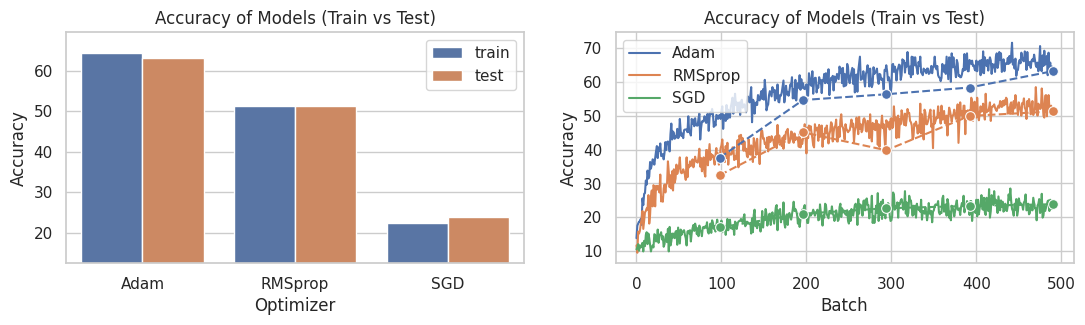

In [ ]:
optim_dict = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
    "Adadelta": torch.optim.Adadelta,
}


optimizer_1 = "Adam" # @param ["Adam", "SGD", "RMSprop", "Adadelta"]
optimizer_2 = "RMSprop"  # @param ["Adam", "SGD", "RMSprop", "Adadelta"]
optimizer_3 = "SGD"  # @param ["Adam", "SGD", "RMSprop", "Adadelta"]



optimizers = [  optim_dict[optimizer_1], optim_dict[optimizer_2], optim_dict[optimizer_3] ]

historys = []
train_data, test_data = load_data(batch_size=512)

for optimizer in optimizers:
    model = ClassificationNet()
    optimizer = optimizer(model.parameters(), lr=0.01)
    history = tuning_model(optimizer, 5, train_data, test_data, optimizer, model)
    historys.append(history)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
acc_barplot(np.array(historys), ax1, 'Optimizer')
batch_lineplot(np.array(historys), ax = ax2)


## model size comparison

Choosing the right model size involves tradeoffs between computational resources and model performance. Larger models tend to have higher capacity but are more resource intensive to train.



<div align="center"><img src="https://www.researchgate.net/profile/Brian-Davison/publication/339139382/figure/fig2/AS:856873737674754@1581306027943/Top-1-accuracy-versus-network-size-and-parameters-D201-Densenet201-Iv3-Inceptionv3.ppm" width="400" ></div>


- **Tiny Model**
    - **Very low computational requirements:** Suitable for low-power devices or resource-constrained environments.

    - **Lower model capacity:** Limited ability to capture complex patterns and nuances in the data.

    - **May struggle to fit complex patterns:** Might not perform well on tasks that require advanced feature extraction.

- **Small Model**
    - **Low computational requirements:** Can run on modest hardware and may be suitable for lightweight applications.

    - **Reasonable model capacity:** Offers a decent balance between resource usage and performance.

    - **Can fit moderately complex patterns:** Adequate for tasks with moderate levels of intricacy

- **Medium Model**
    - **Moderate computational requirements:** Requires more computing power than smaller models but offers improved performance.

    - **Good model capacity:** Strikes a balance between complexity and efficiency, suitable for a wide range of tasks.

    - **Can fit more complex patterns:** Effective in capturing intricate relationships in the data.

- **Large Model**
    - **High computational requirements:** Demands substantial computational resources for training and inference.

    - **Very high model capacity:** Capable of capturing fine-grained details and complex relationships.

    - **Can fit extremely complex patterns:** Well-suited for tasks that involve highly intrincate or nuanced data patterns.

    - **Risk of overfitting due to high capacity:** Prone to overfitting when training data is limited or noisy.

The optimal model size depends on the problem complexity, amount of training data, and available computational resources. Smaller models train faster while larger models can fit more intricate patterns. The model size should be chosen to provide a good balance.

Starting training epoch 0
Test: 	Time 0.016 (0.008)	Data 0.000 (0.000)	Loss 2.1612 (2.1613)	Accuracy 30.867 (32.080)
Starting training epoch 1
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 2.0483 (2.0603)	Accuracy 44.643 (42.370)
Starting training epoch 2
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 2.0004 (2.0137)	Accuracy 47.832 (46.240)
Starting training epoch 3
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 1.9702 (1.9801)	Accuracy 50.638 (49.450)
Starting training epoch 4
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 1.9484 (1.9564)	Accuracy 52.679 (52.060)
Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0380 (2.0496)	Accuracy 45.281 (43.270)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9300 (1.9467)	Accuracy 56.760 (54.480)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8912 (1.8999)	Accuracy 58.546 (58.000)
Starting training epoch 3
Test: 	Time 0.014 (0.019)	Data 0.000 (

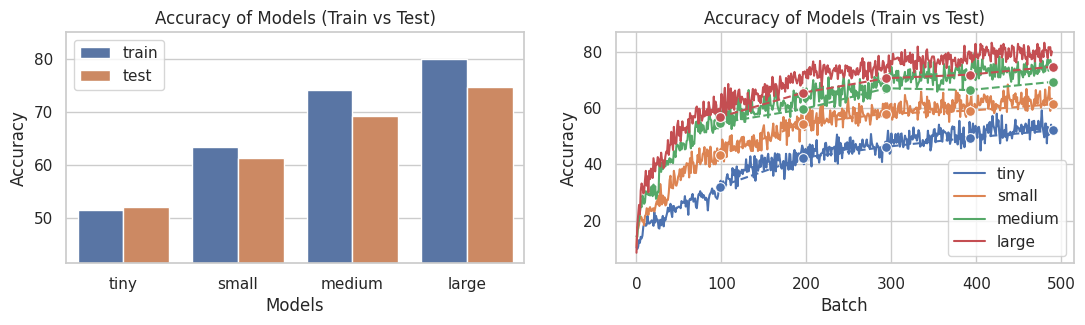

In [ ]:
tiny = ClassificationNet(features = 8, num_layers = 4, name = "tiny")

small = ClassificationNet(features = 16, num_layers = 4, name = "small")

medium = ClassificationNet(features = 32, num_layers = 4, name = "medium")

large = ClassificationNet(features = 64, num_layers = 4, name = "large")

models = [ tiny, small, medium, large ]


historys = []
train_data, test_data = load_data(batch_size=512)

for model in models:
    history = tuning_model(model.name, 5, train_data, test_data,model= model)
    historys.append(history)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

acc_barplot(np.array(historys), ax = ax1)
batch_lineplot(np.array(historys), ax = ax2)